In [11]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np


In [4]:
df_data = pd.read_csv('data/histopathologic-cancer-detection/train_labels.csv')


print(len(os.listdir('data/histopathologic-cancer-detection/train')))
print(len(os.listdir('data/histopathologic-cancer-detection/test')))

440050
114916


In [5]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    
    df[col_name]=  df[col_name].astype(float)
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

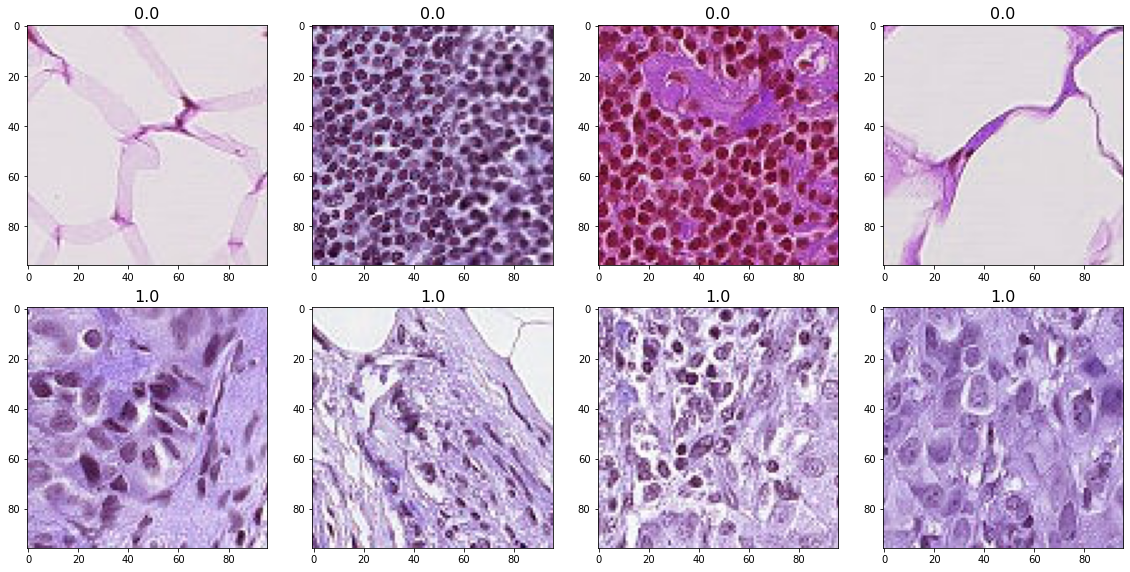

In [6]:
draw_category_images('label',4, df_data,'data/histopathologic-cancer-detection/train/')

In [8]:
from sklearn.model_selection import train_test_split

y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train)
print(df_val)
print(y)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


                                              id  label
134709  2ddb582347063e13f6e8e8bcc693c2ddc65f5781    0.0
122063  9563cbc9f43d2d2ecc1e8b757ee85637db430fe7    0.0
171972  2ca2f3a7c24ba5c5638089e1c08088ac246454fe    1.0
63378   ab452f00d0fc2a3dd7c4781c0dcaaecf4d71e4ab    1.0
36782   85aaec3a61c47e33d4bad167f9c1a013a2ff2401    0.0
...                                          ...    ...
117398  9e04c5701b81604b04bd340fb86f26c0ec0fa84d    0.0
87646   86611a3dae286bf57808cce6bd952777a83e2f98    0.0
99059   7344089a9732d851d3a5d41cf9c7849e53fc1e94    0.0
121588  a49c538708c85c9be22946c40e284d357bf960b5    0.0
21829   d7a3e35ffb2dfa20db4aff2c9e91edb64f4a369c    0.0

[198022 rows x 2 columns]
                                              id  label
79961   0d8c9abf388785a016d72e609ab932b7e134f827    0.0
45724   5566aa9c1d698535c449144d72e98556bf77fd47    0.0
81384   358c0ab1962f8f1c202b146d88b35f55252bde9f    1.0
91989   00f81cefedcc1fb79a5c500677aad14438c50296    0.0
177529  e7a806a270062

In [9]:
import os
import shutil

base_dir = 'data/histopathologic-cancer-detection/split'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

no_tumor_tissue = os.path.join(train_dir, 'tumor_0')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'tumor_1')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'tumor_0')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'tumor_1')
os.mkdir(has_tumor_tissue)

df_data_ind = df_data.set_index('id')

train_list = list(df_train['id'])
val_list = list(df_val['id'])

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data_ind.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'tumor_0'
    if target == 1:
        label = 'tumor_1'
    
    # source path to image
    src = os.path.join('data/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data_ind.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'tumor_0'
    if target == 1:
        label = 'tumor_1'
    

    # source path to image
    src = os.path.join('data/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [43]:
from keras.preprocessing.image import ImageDataGenerator

train_path = 'data/histopathologic-cancer-detection/split/train_dir'
valid_path = 'data/histopathologic-cancer-detection/split/val_dir'
test_path ='data/histopathologic-cancer-detection/test'

img_size = 96
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 32
val_batch_size = 32


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

datagen = ImageDataGenerator(rescale=1.0/255)

datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
                            horizontal_flip=True,
                            vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(img_size,img_size),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(img_size,img_size),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(img_size,img_size),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

Found 198022 images belonging to 2 classes.
Found 22003 images belonging to 2 classes.
Found 22003 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D,MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [59]:
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
                              
                              
callbacks_list = [reducel, earlystopper]

In [ ]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

In [52]:

model1 = Sequential()
model1.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model1.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model1.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model1.add(MaxPooling2D(pool_size = pool_size)) 
model1.add(Dropout(dropout_conv))

model1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model1.add(MaxPooling2D(pool_size = pool_size))
model1.add(Dropout(dropout_conv))

model1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model1.add(MaxPooling2D(pool_size = pool_size))
model1.add(Dropout(dropout_conv))

model1.add(Flatten())
model1.add(Dense(256, activation = "relu"))
model1.add(Dropout(dropout_dense))
model1.add(Dense(1, activation = "softmax"))

model1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 conv2d_76 (Conv2D)          (None, 92, 92, 32)        9248      
                                                                 
 conv2d_77 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_36 (Dropout)        (None, 45, 45, 32)        0         
                                                                 
 conv2d_78 (Conv2D)          (None, 43, 43, 64)        18496     
                                                     

In [54]:
model1.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

filepath1 = "model.h5"

history = model1.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=10, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/10
6189/6189 [==============================] - ETA: 0s - loss: 0.4403 - accuracy: 0.4050WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6189/6189 [==============================] - 5032s 813ms/step - loss: 0.4403 - accuracy: 0.4050 - val_loss: 0.3873 - val_accuracy: 0.4050 - lr: 1.0000e-04
Epoch 2/10
6189/6189 [==============================] - ETA: 0s - loss: 0.3365 - accuracy: 0.4050WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6189/6189 [==============================] - 4939s 798ms/step - loss: 0.3365 - accuracy: 0.4050 - val_loss: 0.3155 - val_accuracy: 0.4050 - lr: 1.0000e-04
Epoch 3/10
6189/6189 [==============================] - ETA: 0s - loss: 0.2955 - accuracy: 0.4050WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6189/6189 [==============================] - 4871s 787ms/step - loss: 0.2955 - accuracy: 0.4050 - val_loss: 0.3143 - val_accuracy: 0.4050 - lr: 1.0000e-04
Epoch 4/10
4824/6189 [======================>.......] - ETA: 17:33 - loss: 0.2757 - accuracy: 0.4054

KeyboardInterrupt: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


<Figure size 432x288 with 0 Axes>

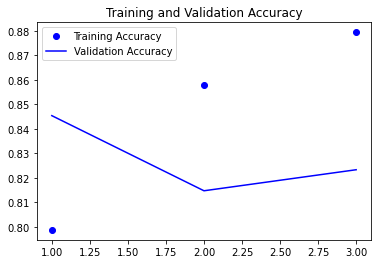

<Figure size 432x288 with 0 Axes>

In [76]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

In [58]:

model2 = Sequential()
model2.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (img_size, img_size, 3)))
model2.add(Conv2D(first_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPool2D(pool_size = pool_size)) 
model2.add(Dropout(dropout_conv))

model2.add(Conv2D(second_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Conv2D(second_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPool2D(pool_size = pool_size))
model2.add(Dropout(dropout_conv))

model2.add(Conv2D(third_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Conv2D(third_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPool2D(pool_size = pool_size))
model2.add(Dropout(dropout_conv))

#model2.add(GlobalAveragePooling2D())
model2.add(Flatten())
model2.add(Dense(256, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Dropout(dropout_dense))
model2.add(Dense(1, activation = "sigmoid"))


model2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 conv2d_91 (Conv2D)          (None, 92, 92, 32)        9216      
                                                                 
 batch_normalization_18 (Ba  (None, 92, 92, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_18 (Activation)  (None, 92, 92, 32)        0         
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 46, 46, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_44 (Dropout)        (None, 46, 46, 32)      

In [69]:

model2.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])
           
history2 = model2.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/20
6189/6189 [==============================] - 4910s 792ms/step - loss: 0.3321 - accuracy: 0.8581 - val_loss: 0.4802 - val_accuracy: 0.8067 - lr: 1.0000e-04
Epoch 2/20
6189/6189 [==============================] - ETA: 0s - loss: 0.2968 - accuracy: 0.8769
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
6189/6189 [==============================] - 9507s 2s/step - loss: 0.2968 - accuracy: 0.8769 - val_loss: 0.5007 - val_accuracy: 0.8105 - lr: 1.0000e-04
Epoch 3/20
6189/6189 [==============================] - ETA: 0s - loss: 0.2679 - accuracy: 0.8916
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Restoring model weights from the end of the best epoch: 1.
6189/6189 [==============================] - 10485s 2s/step - loss: 0.2679 - accuracy: 0.8916 - val_loss: 0.5360 - val_accuracy: 0.8087 - lr: 1.0000e-05
Epoch 3: early stopping


<Figure size 432x288 with 0 Axes>

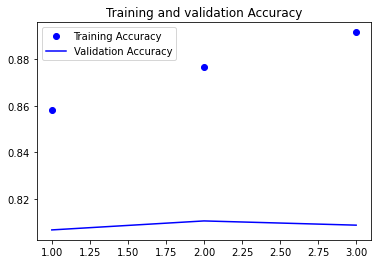

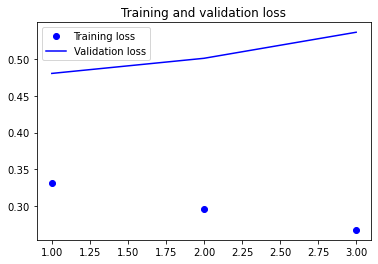

<Figure size 432x288 with 0 Axes>

In [78]:

acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs2 = range(1, len(acc) + 1)

plt.plot(epochs2, acc2, 'bo', label='Training Accuracy')
plt.plot(epochs2, val_acc2, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.legend()
plt.figure()


plt.plot(epochs2, loss2, 'bo', label='Training loss')
plt.plot(epochs2, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()